In [ ]:
# Instalasi dependensi untuk PySpark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark pyspark

--2025-06-12 14:10:16--  https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400446614 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.1-bin-hadoop3.tgz’

spark-3.5.1-bin-had 100%[===================>] 381.90M  2.15MB/s    in 1m 57s  

2025-06-12 14:12:14 (3.26 MB/s) - ‘spark-3.5.1-bin-hadoop3.tgz’ saved [400446614/400446614]



In [ ]:
# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"


In [ ]:
# Inisialisasi Spark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("AnalisisMobilBesar").getOrCreate()
print("Spark berhasil diinisialisasi.")


Spark berhasil diinisialisasi.


In [ ]:
# Impor library untuk preprocessing, visualisasi, dan penanganan file
from pyspark.sql.functions import col, when, avg, round, regexp_replace
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
from google.colab import drive

In [ ]:
# Mount Google Drive untuk menyimpan hasil
drive.mount('/content/drive')
# Unggah dataset

print("Silakan unggah file 'Large Cars Dataset.csv'")
uploaded = files.upload()

# Muat dataset dari file yang diunggah
file_name = list(uploaded.keys())[0]  # Ambil nama file yang diunggah
df = spark.read.csv(file_name, header=True, inferSchema=True)


Mounted at /content/drive
Silakan unggah file 'Large Cars Dataset.csv'


Saving Large Cars Dataset.csv to Large Cars Dataset.csv


In [ ]:
# --- Preprocessing ---
# 1. Bersihkan kolom MSRP dan DealerCost (hapus '$' dan koma, ubah ke float)
df = df.withColumn("MSRP", regexp_replace(col("MSRP"), "[$,]", "").cast("float"))
df = df.withColumn("DealerCost", regexp_replace(col("DealerCost"), "[$,]", "").cast("float"))

# 2. Tangani nilai null atau kosong di kolom Cylinders
df = df.withColumn("Cylinders", when(col("Cylinders").isNull() | (col("Cylinders") == ""), 0).otherwise(col("Cylinders").cast("integer")))

# 3. Hapus baris dengan nilai null di kolom penting
df_clean = df.na.drop(subset=["MSRP", "HorsePower", "Weight", "MPG_City", "MPG_Highway"])

# 4. Hapus duplikasi
df_clean = df_clean.dropDuplicates()

# 5. Transformasi: Buat kolom MPG_Average
df_clean = df_clean.withColumn("MPG_Average", round((col("MPG_City") + col("MPG_Highway")) / 2, 2))

# 6. Transformasi: Kategorisasi HorsePower
df_clean = df_clean.withColumn("HP_Category",
                              when(col("HorsePower") < 150, "Low")
                              .when(col("HorsePower") <= 250, "Medium")
                              .otherwise("High"))

# 7. Filter anomali (misalnya, nilai negatif)
df_clean = df_clean.filter((col("HorsePower") > 0) & (col("Weight") > 0) & (col("MSRP") > 0))


In [ ]:
# Simpan data yang telah dibersihkan ke Google Drive
output_path = "/content/drive/My Drive/Large_Cars_Cleaned.csv"
df_clean.coalesce(1).write.csv(output_path, header=True, mode="overwrite")
print(f"Data yang telah dibersihkan disimpan di: {output_path}")

# Simpan ke file lokal dan unduh sebagai CSV tunggal
df_clean.coalesce(1).write.csv("temp_cleaned_csv", header=True, mode="overwrite")
# Pindahkan file CSV dari direktori temp ke file tunggal
for file in os.listdir("temp_cleaned_csv"):
    if file.endswith(".csv"):
        os.rename(f"temp_cleaned_csv/{file}", "Large_Cars_Cleaned.csv")
        break
files.download("Large_Cars_Cleaned.csv")
print("File CSV hasil pembersihan telah diunduh sebagai Large_Cars_Cleaned.csv")


Data yang telah dibersihkan disimpan di: /content/drive/My Drive/Large_Cars_Cleaned.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File CSV hasil pembersihan telah diunduh sebagai Large_Cars_Cleaned.csv


In [ ]:
# --- Exploratory Data Analysis (EDA) ---
# Konversi ke Pandas untuk visualisasi
df_pandas = df_clean.toPandas()

# Statistik Deskriptif
print("Statistik Deskriptif:")
print(df_pandas[["MSRP", "EngineSize", "HorsePower", "MPG_Average", "Weight"]].describe())


Statistik Deskriptif:
                MSRP  EngineSize  HorsePower  MPG_Average       Weight
count     428.000000  428.000000  428.000000   428.000000   428.000000
mean    32774.855469    3.196729  215.885514    23.452103  3577.953271
std     19431.716797    1.108595   71.836032     5.408331   758.983215
min     10280.000000    1.300000   73.000000    11.000000  1850.000000
25%     20334.250000    2.375000  165.000000    20.500000  3104.000000
50%     27635.000000    3.000000  210.000000    23.000000  3474.500000
75%     39205.000000    3.900000  255.000000    25.500000  3977.750000
max    192465.000000    8.300000  500.000000    63.000000  7190.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

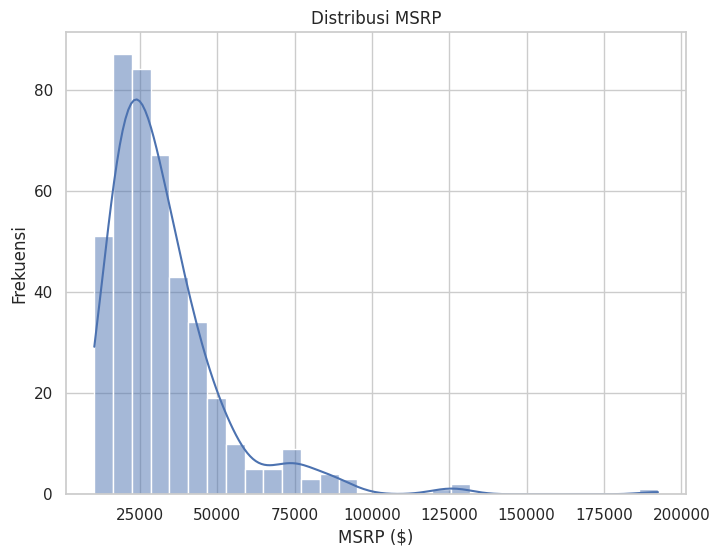

Histogram MSRP disimpan di Google Drive dan diunduh sebagai msrp_histogram.png


In [ ]:
# --- Visualisasi ---
sns.set_theme(style="whitegrid")

# 1. Histogram MSRP
plt.figure(figsize=(8, 6))
sns.histplot(df_pandas["MSRP"], bins=30, kde=True)
plt.title("Distribusi MSRP")
plt.xlabel("MSRP ($)")
plt.ylabel("Frekuensi")
plt.savefig("/content/drive/My Drive/msrp_histogram.png")
plt.savefig("msrp_histogram.png")
files.download("msrp_histogram.png")
plt.show()
print("Histogram MSRP disimpan di Google Drive dan diunduh sebagai msrp_histogram.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

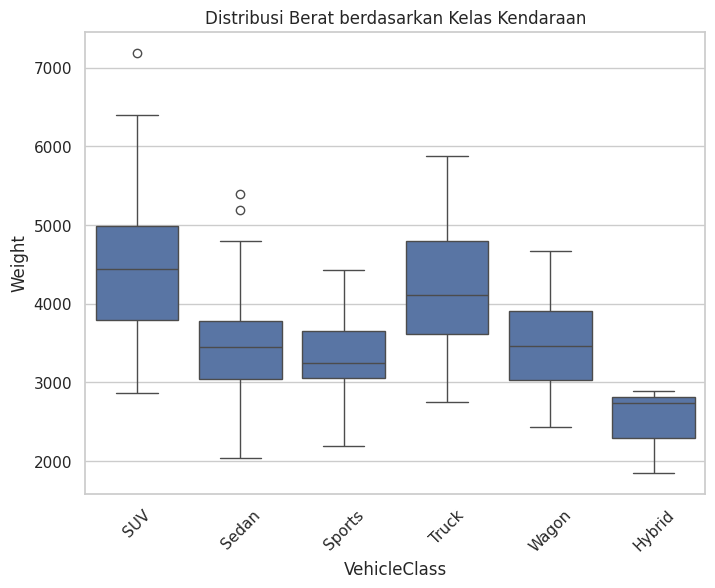

Box Plot Berat disimpan di Google Drive dan diunduh sebagai weight_boxplot.png


In [ ]:
# 2. Box Plot Weight berdasarkan VehicleClass
plt.figure(figsize=(8, 6))
sns.boxplot(x="VehicleClass", y="Weight", data=df_pandas)
plt.title("Distribusi Berat berdasarkan Kelas Kendaraan")
plt.xticks(rotation=45)
plt.savefig("/content/drive/My Drive/weight_boxplot.png")
plt.savefig("weight_boxplot.png")
files.download("weight_boxplot.png")
plt.show()
print("Box Plot Berat disimpan di Google Drive dan diunduh sebagai weight_boxplot.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

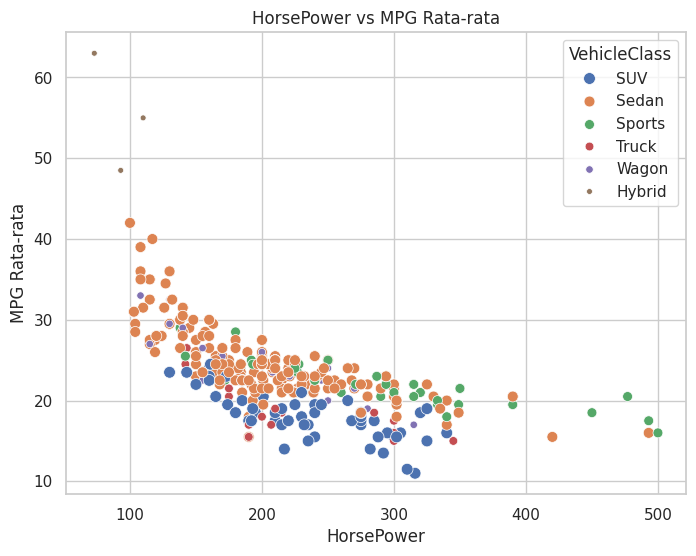

Scatter Plot HorsePower vs MPG Rata-rata disimpan di Google Drive dan diunduh sebagai horsepower_mpg_scatter.png


In [ ]:
# 3. Scatter Plot HorsePower vs MPG_Average
plt.figure(figsize=(8, 6))
sns.scatterplot(x="HorsePower", y="MPG_Average", hue="VehicleClass", size="VehicleClass", data=df_pandas)
plt.title("HorsePower vs MPG Rata-rata")
plt.xlabel("HorsePower")
plt.ylabel("MPG Rata-rata")
plt.savefig("/content/drive/My Drive/horsepower_mpg_scatter.png")
plt.savefig("horsepower_mpg_scatter.png")
files.download("horsepower_mpg_scatter.png")
plt.show()
print("Scatter Plot HorsePower vs MPG Rata-rata disimpan di Google Drive dan diunduh sebagai horsepower_mpg_scatter.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

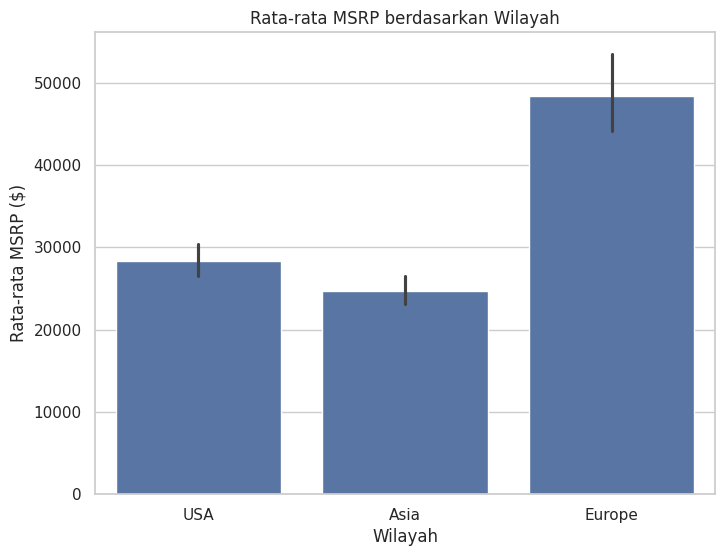

Bar Plot MSRP berdasarkan Wilayah disimpan di Google Drive dan diunduh sebagai msrp_region_barplot.png


In [ ]:
# 4. Bar Plot Rata-rata MSRP berdasarkan Region
plt.figure(figsize=(8, 6))
sns.barplot(x="Region", y="MSRP", data=df_pandas, estimator=np.mean)
plt.title("Rata-rata MSRP berdasarkan Wilayah")
plt.xlabel("Wilayah")
plt.ylabel("Rata-rata MSRP ($)")
plt.savefig("/content/drive/My Drive/msrp_region_barplot.png")
plt.savefig("msrp_region_barplot.png")
files.download("msrp_region_barplot.png")
plt.show()
print("Bar Plot MSRP berdasarkan Wilayah disimpan di Google Drive dan diunduh sebagai msrp_region_barplot.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

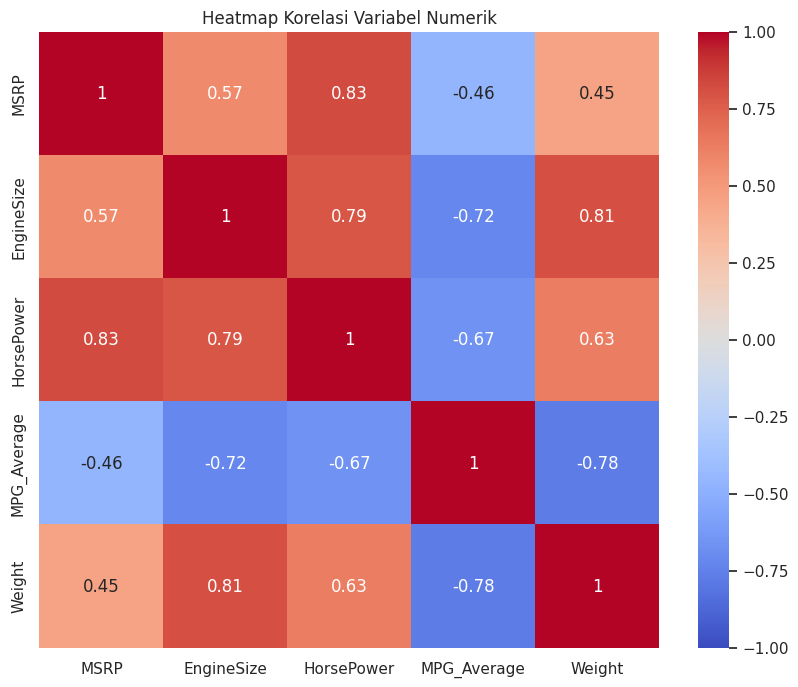

Heatmap Korelasi disimpan di Google Drive dan diunduh sebagai correlation_heatmap.png


In [ ]:
# 5. Heatmap Korelasi
plt.figure(figsize=(10, 8))
corr = df_pandas[["MSRP", "EngineSize", "HorsePower", "MPG_Average", "Weight"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Heatmap Korelasi Variabel Numerik")
plt.savefig("/content/drive/My Drive/correlation_heatmap.png")
plt.savefig("correlation_heatmap.png")
files.download("correlation_heatmap.png")
plt.show()
print("Heatmap Korelasi disimpan di Google Drive dan diunduh sebagai correlation_heatmap.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

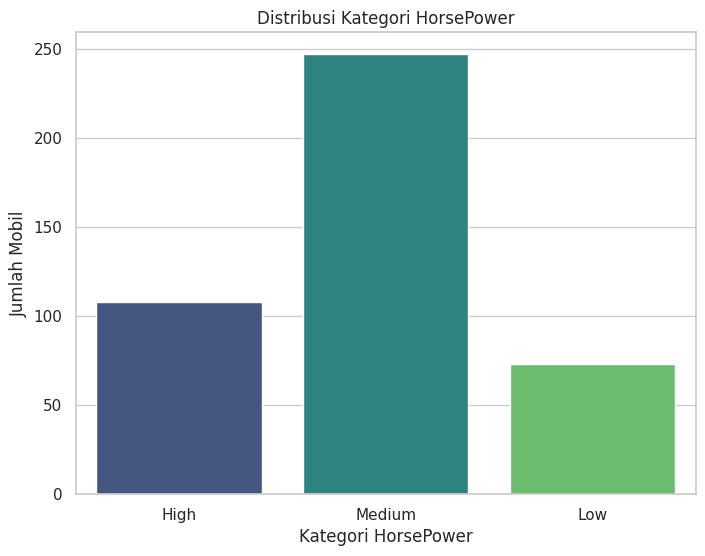

Count Plot Kategori HorsePower disimpan di Google Drive dan diunduh.


In [ ]:
# 6. Count Plot HP_Category
plt.figure(figsize=(8, 6))
sns.countplot(x="HP_Category", hue="HP_Category", data=df_pandas, palette="viridis", legend=False)
plt.title("Distribusi Kategori HorsePower")
plt.xlabel("Kategori HorsePower")
plt.ylabel("Jumlah Mobil")
plt.savefig("/content/drive/My Drive/hp_category_countplot.png")
plt.savefig("hp_category_countplot.png")
files.download("hp_category_countplot.png")
plt.show()
print("Count Plot Kategori HorsePower disimpan di Google Drive dan diunduh.")
